In [26]:
# IMAGE CONFIGURATIONS
IMAGE_SIZE = [224, 224]

# TRAINING CONFIGURATIONS
epochs = 3
batch_size = 128

## Preparing Data

In [2]:
import pandas as pd
df_train_data = pd.read_csv('../data/train_images_filtered_no_duplicates.csv')
df_train_data

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4
...,...,...
26280,1778392170.jpg,2
26281,2495608764.jpg,3
26282,698646619.jpg,4
26283,297559984.jpg,3


In [3]:
df_train_data.labels.value_counts()

labels
3    15452
1     3451
2     3014
4     2888
0     1480
Name: count, dtype: int64

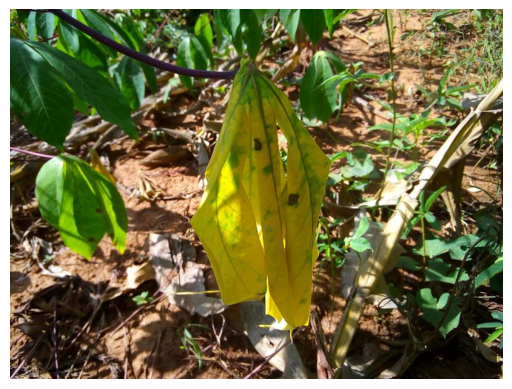

In [4]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = "../data/train_images/"

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [5]:
unique_labels = df_train_data.labels.value_counts()
num_unique_labels = unique_labels.nunique()


In [6]:
from sklearn import model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.2, random_state=109, stratify=df_train_data["labels"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [7]:
from torch.utils.data import Dataset
import os
import cv2
class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['labels'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
proc_resize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = IMAGE_SIZE)
        ])
train_df = ConstDataset(df_train, transform=proc_resize)

In [9]:
import torch
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [10]:
from tqdm import tqdm
def calc_mean_std(train_df, trainloader):
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|██████████| 165/165 [01:03<00:00,  2.61it/s]


In [11]:
proc_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=calc_mean,std=calc_std)
])

In [13]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

desired_majority_class_size = 6000

class_counts = df_train["labels"].value_counts()
undersample_strategy = {class_counts.idxmax(): desired_majority_class_size}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=109)
X_under, y_under = rus.fit_resample(
    df_train["image_id"].values.reshape(-1, 1), df_train["labels"].values
)

desired_minority_class_size = 6000

ros = RandomOverSampler(
    sampling_strategy={
        label: desired_minority_class_size
        for label in class_counts.index
        if class_counts[label] < desired_minority_class_size
    },
    random_state=109,
)
X_resampled, y_resampled = ros.fit_resample(X_under, y_under)

df_train_resampled = pd.DataFrame(
    {"image_id": X_resampled.flatten(), "labels": y_resampled}
)

# Check the new class distribution
print(df_train_resampled["labels"].value_counts())

df_train_resampled.reset_index(drop=True, inplace=True)

labels
0    6000
1    6000
2    6000
3    6000
4    6000
Name: count, dtype: int64


In [14]:
train_df = ConstDataset(df_train_resampled, transform=proc_aug)
valid_df = ConstDataset(df_valid, transform=proc_aug)

In [15]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0),
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}

## Training model

In [ ]:
# !pip install torch torchvision
# !pip install transformers datasets
# !pip install transformers[torch]

In [27]:
import torch.nn as nn
import torch.optim as optim
from transformers import ViTForImageClassification, TrainingArguments, Trainer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [28]:
model_name = "google/vit-base-patch16-224"
num_classes = num_unique_labels

model = ViTForImageClassification.from_pretrained(
    model_name, num_labels=num_classes, ignore_mismatched_sizes=True
)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=5, bias=True)


In [29]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [31]:
!pip show accelerate

Name: accelerate
Version: 0.31.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /home/samic_yongjian/miniconda3/lib/python3.11/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [32]:
# Training arguments configuration
args = TrainingArguments(
    output_dir="../output/vit/model",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="../output/vit/logs",
    remove_unused_columns=False,
    logging_steps=50,
)


# Collate function for combining samples into batches
def collate_fn(examples):
    images = torch.stack([example[0] for example in examples])  # Stack images
    labels = torch.tensor([example[1] for example in examples])  # Stack labels
    return {"pixel_values": images, "labels": labels}


# Metric computation (accuracy)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}


# Initialize the trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_df,
    eval_dataset=valid_df,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,  
)

In [33]:
%load_ext tensorboard
%tensorboard --logdir ../output/logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 785001), started 14 days, 3:44:54 ago. (Use '!kill 785001' to kill it.)

In [34]:
trainer.train()

/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.120100,0.661698,0.775537
2,0.715200,0.582853,0.793609
3,0.612800,0.544896,0.809777


/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=177, training_loss=0.7799485308975823, metrics={'train_runtime': 576.9376, 'train_samples_per_second': 155.996, 'train_steps_per_second': 0.307, 'total_flos': 6.97446659008512e+18, 'train_loss': 0.7799485308975823, 'epoch': 3.0})

In [46]:
outputs = trainer.predict(valid_df)
print(outputs.metrics)

/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.5120325684547424, 'test_accuracy': 0.8189209164818921, 'test_runtime': 25.2443, 'test_samples_per_second': 107.192, 'test_steps_per_second': 0.238}


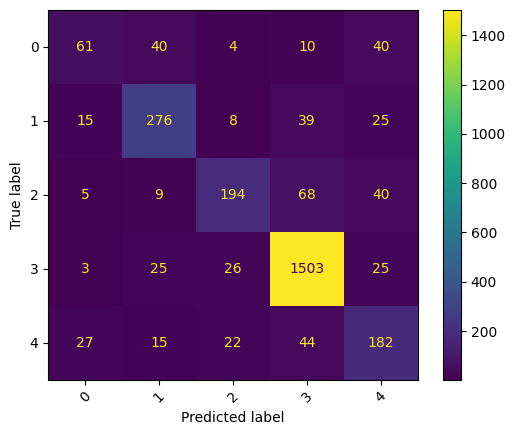

In [47]:
y_true = outputs.label_ids
y_pred = np.argmax(outputs.predictions, axis=1)

labels = np.unique(train_df.labels)
cm = confusion_matrix(y_true, y_pred, labels = labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)